In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump


import warnings
warnings.filterwarnings("ignore")

In [4]:
from matplotlib import style 
plt.style.use('ggplot')

In [5]:
all_stocks = pd.read_csv('stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


Filter Tesla & convert data format

In [6]:
stock_df = all_stocks[all_stocks['Stock Name'] == "TSLA"]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [7]:
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
247,2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,TSLA
248,2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,TSLA
249,2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,TSLA
250,2022-09-28,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,TSLA


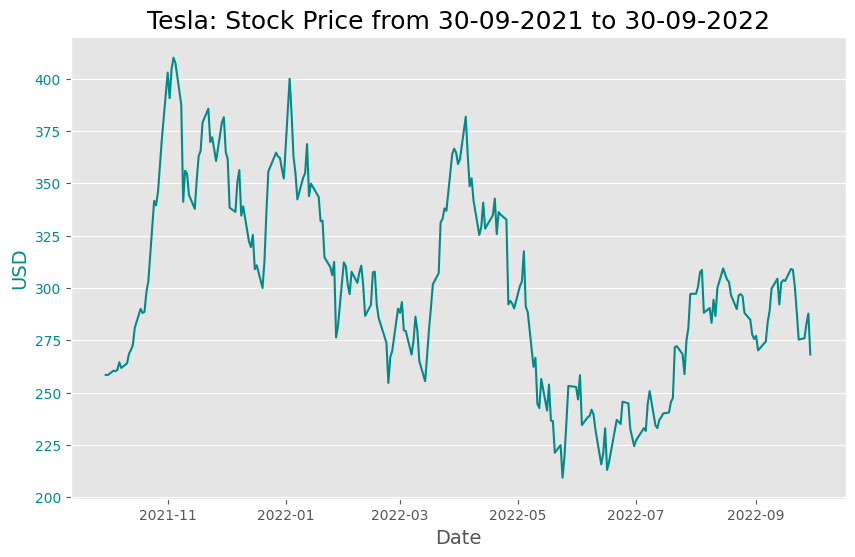

In [8]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot the stock price on ax1
ax1.plot(stock_df['Date'], stock_df['Close'], color='#008B8B', label='Stock Price')
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('USD', fontsize=14, color='#008B8B')
ax1.tick_params(axis='y', labelcolor='#008B8B')

# Set the title for the plot
ax1.set_title(f"Tesla: Stock Price from 30-09-2021 to 30-09-2022", fontsize=18)

# Optional: Add a legend
lines, labels = ax1.get_legend_handles_labels()

plt.grid(axis='x')
plt.show()

### Convert index to dates

In [9]:
finance_df = stock_df.copy()

In [10]:
finance_df.iloc[:, 1:] = pd.concat([finance_df.iloc[:, 1:].ffill()])

In [11]:
datetime_series = pd.to_datetime(finance_df['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = finance_df.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [12]:
dataset

,Open,High,Low,Close,Adj Close,Volume,Stock Name
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...
2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,TSLA
2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,TSLA
2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,TSLA
2022-09-28,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,TSLA


In [13]:
dataset2 = dataset['Close']

In [14]:
def split_train_test(data, test_days=50):
    # test data = latest 20 days
    train_size = len(data) - test_days
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [15]:
dataset_train, dataset_test = split_train_test(dataset2)

In [16]:
dataset_train, dataset_test = np.array(dataset_train).reshape(-1, 1), np.array(dataset_test).reshape(-1, 1)

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
# Normalizing values between 0 and 1 using training data to fit
scaler.fit(dataset_train)
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)

In [26]:
scaled_train.shape

(202, 1)

In [27]:
scaled_test.shape

(50, 1)

### Sequencing

In [21]:
def sequencing(data, sequence_size=40):
    X, y = [],[]
    for i in range(len(data) - sequence_size):
        X.append(data[i:i+sequence_size]) # day0 to day39
        y.append(data[i+1 :i+sequence_size+1]) # day1 to day40
    return np.array(X), np.array(y)

In [22]:
X_train, y_train = sequencing(scaled_train, sequence_size=40)
X_test, y_test = sequencing(scaled_test, sequence_size=20)

In [24]:
X_train.shape

(162, 40, 1)

In [28]:
print(X_train.shape) # 1 + 232 - 21 = 212
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(162, 40, 1)
(162, 40, 1)
(30, 20, 1)
(30, 20, 1)


In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
import torch
# Assuming X_train, y_train, X_test, y_test are already loaded as numpy arrays

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create Tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create Data Loaders
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
X_test_tensor.shape

torch.Size([30, 20, 1])

# Model Building

In [33]:
class AdvancedLSTMModel(nn.Module):
    def __init__(self, input_dim, feature_size, hidden_dim, output_dim, num_layers=3, dropout=0.3
    , device=device):
        super(AdvancedLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=feature_size, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            dropout=dropout if num_layers > 1 else 0.0)  # Dropout only between LSTM layers if num_layers > 1
        #self.batch_norm = nn.BatchNorm1d(input_dim)  # Normalizing the inputs for each time step
        self.linear = nn.Linear(hidden_dim, output_dim)  # Output layer
        self.device = device

    def forward(self, x):
        # Batch normalization
        #x = self.batch_norm(x)
        
        # Initialize hidden and cell states
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(self.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(self.device)
        out, _ = self.lstm(x)
        # Tx = Ty because each step (i) predicts one output (i+1)
        #out = self.linear(out)
        out = self.linear(out)
        return out

In [34]:
y_train.shape

(162, 40, 1)

In [45]:
X_train.shape[1] 

40

In [35]:
# Model configuration
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[2]
hidden_dim = 64

model = AdvancedLSTMModel(input_dim, feature_size, hidden_dim, output_dim)
model = model.to(device)

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00)

# Training

In [36]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    model.train()
    train_hist = []
    test_hist = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_hist.append(avg_train_loss)
        
        # Testing phase
        model.eval()
        total_test_loss = 0
        with torch.no_grad():  # Disable gradient computation during evaluation
            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = criterion(predictions_test, batch_y_test)
                total_test_loss += test_loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_hist.append(avg_test_loss)
        
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_hist, test_hist

In [37]:
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer)

Epoch 1, Train Loss: 0.1600, Test Loss: 0.1059
Epoch 2, Train Loss: 0.0711, Test Loss: 0.1253
Epoch 3, Train Loss: 0.0676, Test Loss: 0.1055
Epoch 4, Train Loss: 0.0647, Test Loss: 0.0866
Epoch 5, Train Loss: 0.0566, Test Loss: 0.0978
Epoch 6, Train Loss: 0.0477, Test Loss: 0.0861
Epoch 7, Train Loss: 0.0353, Test Loss: 0.0880
Epoch 8, Train Loss: 0.0302, Test Loss: 0.0758
Epoch 9, Train Loss: 0.0259, Test Loss: 0.0697
Epoch 10, Train Loss: 0.0217, Test Loss: 0.0716
Epoch 11, Train Loss: 0.0195, Test Loss: 0.0651
Epoch 12, Train Loss: 0.0186, Test Loss: 0.0633
Epoch 13, Train Loss: 0.0171, Test Loss: 0.0598
Epoch 14, Train Loss: 0.0161, Test Loss: 0.0585
Epoch 15, Train Loss: 0.0152, Test Loss: 0.0547
Epoch 16, Train Loss: 0.0143, Test Loss: 0.0546
Epoch 17, Train Loss: 0.0143, Test Loss: 0.0516
Epoch 18, Train Loss: 0.0133, Test Loss: 0.0495
Epoch 19, Train Loss: 0.0127, Test Loss: 0.0483
Epoch 20, Train Loss: 0.0116, Test Loss: 0.0460
Epoch 21, Train Loss: 0.0116, Test Loss: 0.0443
E

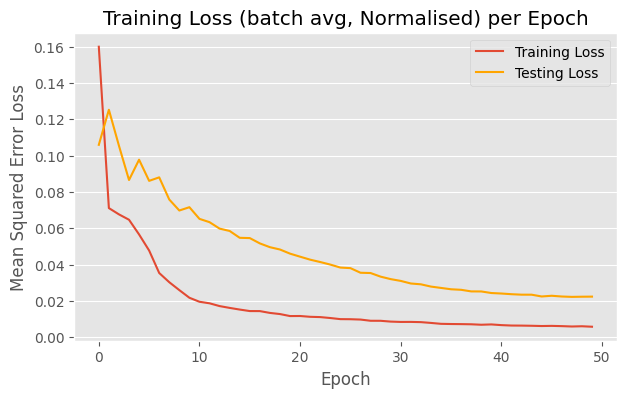

In [38]:
# Plotting the training losses
plt.figure(figsize=(7, 4))
plt.plot(train_losses, linestyle='-', label = 'Training Loss')
plt.plot(test_losses, linestyle='-', color = 'orange', label = 'Testing Loss')

plt.title('Training Loss (batch avg, Normalised) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.grid(axis='x')
plt.legend()
plt.show()

# Prediction Results

After training the neural network on the provided data, now comes the forecasting for next month. The model predicts the future opening price and store the future values along with their corresponding dates. Using for loop, we are going to perform a rolling forecasting, the steps are as follows –

- We have set the future time steps to 30 and converted the test sequence to numpy array and remove singleton dimensions using sequence_to_plot.
- Then, we have converted historical_data to a Pytorch tensor. The shape of the tensor is (1, sequence_length, 1), where sequence_length is the length of the historical data sequence.
- the model further predicts the next value based on the ‘historical_data_tensor’.
- The prediction is then converted to a numpy array and the first element is extracted.

Once the loop ends, we get the forecasted values, which are stored in list, and future dates are generated to create index for these values.

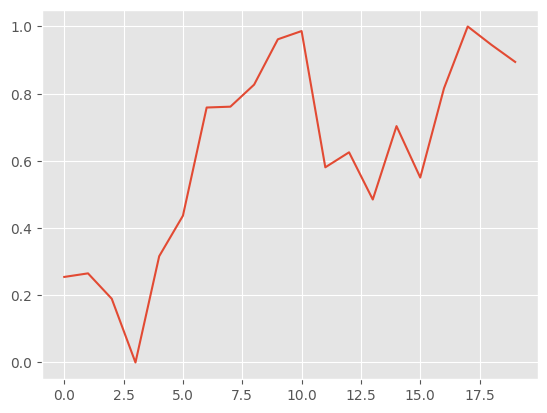

In [40]:
plt.plot(X_test[0])

In [44]:
X_test[0]

array([[0.25459124],
       [0.26522703],
       [0.18972116],
       [0.        ],
       [0.31629043],
       [0.43678159],
       [0.75881871],
       [0.76132918],
       [0.82692561],
       [0.96188389],
       [0.98639168],
       [0.58085643],
       [0.6255121 ],
       [0.4850049 ],
       [0.70346132],
       [0.55033705],
       [0.81589369],
       [1.        ],
       [0.94536896],
       [0.89450394]])

In [41]:
X_test[0].shape

(20, 1)

In [42]:
num_forecast_steps = 50 #20

historical_data = X_test[0]  # This is the last known sequence to start predictions from
forecasted_values = []

In [43]:
historical_data.shape

(20, 1)

In [62]:
model.eval()
model.to(device)
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # 1 tensor data in a batch
        historical_data_tensor = torch.tensor(historical_data, dtype=torch.float32).unsqueeze(0).to(device)
        #print(historical_data_tensor.shape)

        predicted_tensor = model(historical_data_tensor)
        #print(predicted_tensor.shape)

        predicted_value = predicted_tensor.cpu().numpy()[0,0]
        #print(predicted_value)
        forecasted_values.append(predicted_value.tolist())
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value  # Update the sequence with the new prediction

In [63]:
dataset2

2021-09-30    258.493347
2021-10-01    258.406677
2021-10-04    260.510010
2021-10-05    260.196655
2021-10-06    260.916656
                 ...    
2022-09-23    275.329987
2022-09-26    276.010010
2022-09-27    282.940002
2022-09-28    287.809998
2022-09-29    268.209991
Name: Close, Length: 252, dtype: float64

In [64]:
dates = dataset2.index[-50:]

In [66]:
pred_price = scaler.inverse_transform(forecasted_values)[:,0]

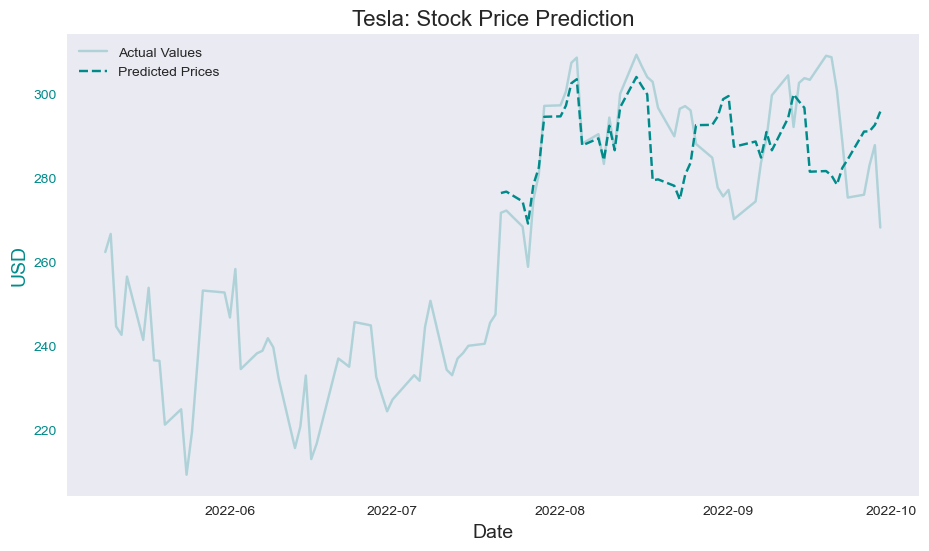

In [74]:
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(dataset2.index[-100:], dataset2[-100:], label='Actual Values', color='#008B8B', alpha=0.25)
ax.plot(dates, pred_price, label='Predicted Prices', color='#008B8B', linestyle='--', alpha=1)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('USD', fontsize=14, color='#008B8B')
ax.tick_params(axis='y', labelcolor='#008B8B')

ax.set_title(f"Tesla: Stock Price Prediction", fontsize=16)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels) #loc='upper right'

#plt.xlim(dataset2.index[-100], dataset2.index[-1])
ax.grid(False)
plt.show()